# ECG Dataset 정의

In [1]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import torch

class Dataset_ECG(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='/tf/hsh/new_ecg/lead2',
                 target='II', scale=True, timeenc=0, freq='s', percent=100,
                 seasonal_patterns=None):
        
        self.seq_len = size
        
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.freq = freq
        self.percent = percent
        
        self.data_x = []
        self.data_y = []
        self.test_data_x = []
        self.test_data_y = []
        self.val_data_x = []
        self.val_data_y = []
        self.root_path = root_path
        self.data_path = os.listdir(root_path)
        self.__read_data__()

        self.enc_in = self.data_x.shape[-1] # 단변량이면 1

    def __read_data__(self):
        self.scaler = StandardScaler()
        
        for i in self.data_path :
            
            df_raw = pd.read_csv(os.path.join(self.root_path,i), index_col=0)
            
            if self.features == 'M' or self.features == 'MS':
                cols_data = df_raw.columns[1:]
                df_data = df_raw[cols_data]
            elif self.features == 'S':
                df_data = df_raw[[self.target]]
    
            if self.scale:
                train_data = df_data
                self.scaler.fit(train_data.values)
                data = self.scaler.transform(train_data.values)
            else:
                data = df_data.values
    
            df_stamp = df_raw.index
            self.data_stamp = df_stamp.values
            
            if i[-5] == '1' or i[-5] == '0':
                self.val_data_x.append(data)
                
                tmp_y = df_raw[['super_class']].iloc[0,0]
                if tmp_y == 'NORM':
                    self.val_data_y.append([1,0])
                else:
                    self.val_data_y.append([0,1])
                    
            elif i[-5] == '2' :
                self.test_data_x.append(data)
                
                tmp_y = df_raw[['super_class']].iloc[0,0]
                if tmp_y == 'NORM':
                    self.test_data_y.append([1,0])
                else:
                    self.test_data_y.append([0,1])
                
            else :
                self.data_x.append(data)
                
                tmp_y = df_raw[['super_class']].iloc[0,0]
                if tmp_y == 'NORM':
                    self.data_y.append([1,0])
                else:
                    self.data_y.append([0,1])
            
            
        self.data_x = torch.tensor(self.data_x)
        self.data_y = torch.tensor(self.data_y)

        print(self.data_x.shape)
        print(self.data_y.shape)

    def __getitem__(self, index):
        return self.data_x[index].unsqueeze(0), self.data_y[index].unsqueeze(0)

    def __len__(self):
        return self.data_x.shape[0]

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [2]:
data_set = Dataset_ECG(root_path='/tf/hsh/new_ecg/lead2', data_path='', size=5000, scale=False)

torch.Size([14953, 2500, 1])
torch.Size([14953, 2])


/tmp/ipykernel_433594/3212616286.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.data_x = torch.tensor(self.data_x)


In [3]:
data_set.data_x.shape

torch.Size([14953, 2500, 1])

In [4]:
data_set.data_y

tensor([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [0, 1],
        [0, 1],
        [0, 1]])

In [5]:
data_set.data_stamp # array

array(['0 days 00:00:00', '0 days 00:00:00.002000',
       '0 days 00:00:00.004000', ..., '0 days 00:00:04.994000',
       '0 days 00:00:04.996000', '0 days 00:00:04.998000'], dtype=object)

In [6]:
len(data_set)

14953

In [7]:
from torch.utils.data import DataLoader

data_loader = DataLoader(
    data_set,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    drop_last=False)

In [8]:
data_set

In [131]:
for i, (batch_x, batch_y) in enumerate(data_loader):
    print(batch_x.shape)
    print(batch_y.shape)

torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])
torch.Size([1, 1, 2500, 1])
torch.Size([1, 1, 2])
tensor([0, 1])


# 모델 학습

In [9]:
import torch.nn as nn

class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Sequential(
                        nn.Linear(nf, 512),
                        nn.ReLU(),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.Linear(128, target_window)
        )
        self.dropout = nn.Dropout(head_dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.sigmoid(x) # 이진분류 아니면 softmax로 바꿔야 함
        
        return x

In [10]:
from math import sqrt

class ReprogrammingLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1):
        super(ReprogrammingLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.value_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, target_embedding, source_embedding, value_embedding):
        B, L, _ = target_embedding.shape 
        S, _ = source_embedding.shape
        H = self.n_heads

        target_embedding = self.query_projection(target_embedding).view(B, L, H, -1)
        source_embedding = self.key_projection(source_embedding).view(S, H, -1)
        value_embedding = self.value_projection(value_embedding).view(S, H, -1)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = out.reshape(B, L, -1)

        return self.out_projection(out)

    def reprogramming(self, target_embedding, source_embedding, value_embedding):
        B, L, H, E = target_embedding.shape

        scale = 1. / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding

In [11]:
import torch
import torch.nn as nn

from layers.StandardNorm import Normalize
from transformers import LlamaConfig, LlamaModel, LlamaTokenizer

class Model(nn.Module):

    def __init__(self):
        super().__init__() 
        self.seq_len = 5000
        self.llm_layers = 32
        self.d_model = 32
        self.d_ff = 128
        self.d_llm = 4096
        self.n_heads = 8
        self.patch_len = 156
        self.stride = 78
        self.enc_in = 1
        self.num_class = 2
        self.dropout_rate = 0.1

        # 모델 정의
        
        self.llama_config = LlamaConfig.from_pretrained('huggyllama/llama-7b')
        self.llama_config.num_hidden_layers = self.llm_layers
        self.llama_config.output_attentions = True
        self.llama_config.output_hidden_states = True

        self.llm_model = LlamaModel.from_pretrained(
                        'huggyllama/llama-7b',
                        trust_remote_code=True,
                        local_files_only=True,
                        config=self.llama_config,
        )

        self.tokenizer = LlamaTokenizer.from_pretrained(
            'huggyllama/llama-7b',
            trust_remote_code=True,
            local_files_only=True
        )

        if self.tokenizer.eos_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            pad_token = '[PAD]'
            self.tokenizer.add_special_tokens({'pad_token': pad_token})
            self.tokenizer.pad_token = pad_token

        for param in self.llm_model.parameters():
            param.requires_grad = False

        # layer 정의
        
        self.dropout = nn.Dropout(self.dropout_rate)
        
        self.patch_embedding = PatchEmbedding(
            self.d_model, self.patch_len, self.stride, self.dropout_rate)

        self.word_embeddings = self.llm_model.get_input_embeddings().weight
        self.vocab_size = self.word_embeddings.shape[0]
        self.num_tokens = 1000
        self.mapping_layer = nn.Linear(self.vocab_size, self.num_tokens)

        self.reprogramming_layer = ReprogrammingLayer(self.d_model, self.n_heads, self.d_ff, self.d_llm)

        self.patch_nums = int((self.seq_len - self.patch_len) / self.stride + 2)
        self.head_nf = self.d_ff * self.patch_nums

        self.output_projection = FlattenHead(
            self.enc_in, self.head_nf, self.num_class, head_dropout=self.dropout_rate)
        
        self.normalize_layers = Normalize(self.enc_in, affine=False)

    def forward(self, x_enc, x_dec, mask=None):
        dec_out = self.classification(x_enc, x_dec)
        return dec_out

    def classification(self, x_enc, x_dec):
        
        x_enc = self.normalize_layers(x_enc, 'norm')

        # prompt embeddings
        prompt = []
        for b in range(x_enc.shape[0]):
            prompt_ = (f"<|start_prompt|>Dataset description: The ECG signal from Lead II, recorded for 10 seconds at a sampling rate of 500 Hz, is provided."
                       f"Task description: Determine whether the patient's ECG signal from Lead II is normal (0) or abnormal (1).<|end_prompt|>")
            prompt.append(prompt_)
        prompt = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids
        prompt_embeddings = self.llm_model.get_input_embeddings()(prompt)
    
        # source embeddings
        source_embeddings = self.mapping_layer(self.word_embeddings.permute(1, 0)).permute(1, 0)
        # patch embeddings & reprogramming layer
        x_enc = x_enc.permute(0, 2, 1).contiguous()
        enc_out, n_vars = self.patch_embedding(x_enc)
        enc_out = self.reprogramming_layer(enc_out, source_embeddings, source_embeddings)

        # LLM
        llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llama_enc_out).last_hidden_state
        dec_out = dec_out[:, :, :self.d_ff] # 이 부분이 필요할까

        dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1]))
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums:])
        dec_out = dec_out.permute(0, 2, 1).contiguous()

        return dec_out # (batch_size X class X 변량)

In [25]:
from layers.Embed import PatchEmbedding
model = Model()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
import matplotlib.pyplot as plt

for epoch in range(1):
    train_loss = []
    tmp = []
    
    model.train()
    for i, (batch_x, batch_y) in enumerate(data_loader):
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        
        outputs = model(batch_x.squeeze(0), batch_y.squeeze())
        
        loss = criterion(outputs.squeeze(), batch_y.squeeze())
        
        if i % 75 == 0 and tmp:
            print(i, outputs.squeeze(), batch_y.squeeze(), sum(tmp)/len(tmp))
            train_loss.append(float(sum(tmp)/len(tmp)))
            tmp = []
            
        tmp.append(float(loss))

        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch} | Train Loss: {sum(train_loss)/len(train_loss):.7f}')
    plt.plot(train_loss)
    plt.show()

75 tensor([0.5000, 1.0000], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.07398323694864908
150 tensor([0.0000, 0.5000], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.08317766189575196
225 tensor([0.0000, 0.5000], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.08779864311218262
300 tensor([0.0000, 0.5000], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.07393569946289062
375 tensor([0.5000, 1.0000], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.05545177459716797
450 tensor([0., 1.], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.0508307933807373
525 tensor([0., 1.], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.05545177459716797
600 tensor([0., 1.], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.0508307933807373
675 tensor([0., 1.], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.07393569946289062
750 tensor([0., 1.], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.08779864311218262
825 tensor([0., 1.], grad_fn=<SqueezeBackward0>) tensor([0., 1.]) 0.06931471824645996
900 tensor([0.500

KeyboardInterrupt: 

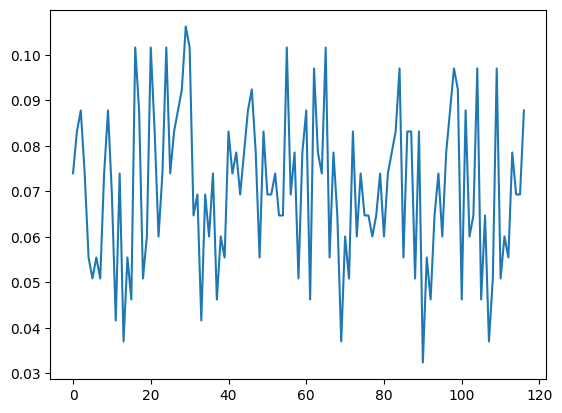

In [30]:
plt.plot(train_loss)
plt.show()

# Test

In [32]:
import torch
import torch.nn as nn

from transformers import LlamaConfig, LlamaModel, LlamaTokenizer

llama_config = LlamaConfig.from_pretrained('huggyllama/llama-7b')
llama_config.num_hidden_layers = 32 # d_model
llama_config.output_attentions = True
llama_config.output_hidden_states = True

llm_model = LlamaModel.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=llama_config,
                    # load_in_4bit=True
                )

for param in llm_model.parameters(): # LLM 파라미터 고정
    param.requires_grad = False

tokenizer = LlamaTokenizer.from_pretrained(
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=True
                )

if tokenizer.eos_token:
    tokenizer.pad_token = tokenizer.eos_token
else:
    pad_token = '[PAD]'
    tokenizer.add_special_tokens({'pad_token': pad_token})
    tokenizer.pad_token = pad_token

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


# Prompt Embedding

In [33]:
prompt_ = (f"<|start_prompt|>Dataset description: The ECG signal from Lead II, recorded for 10 seconds at a sampling rate of 500 Hz, is provided."
           f"Task description: Determine whether the patient's ECG signal from Lead II is normal (0) or abnormal (1).<|end_prompt|>")

In [35]:
prompt = []
for b in range(batch_x.shape[0]):
    prompt.append(prompt_)

In [37]:
prompt = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids

In [38]:
prompt.shape

torch.Size([1, 80])

In [39]:
prompt_embeddings = llm_model.get_input_embeddings()(prompt)

In [40]:
prompt_embeddings.shape

torch.Size([1, 80, 4096])

# Reprogramming_layer
1. source embedding
2. patch embedding -> enc_out
3. 1과 2를 attention 

## source embedding & patch embedding

In [48]:
import torch
import torch.nn as nn
from layers.Embed import PatchEmbedding

patch_embedding = PatchEmbedding(32, 156, 78, 0.1)

word_embeddings = llm_model.get_input_embeddings().weight

vocab_size = word_embeddings.shape[0]
num_tokens = 1000
mapping_layer = nn.Linear(vocab_size, num_tokens)

In [49]:
source_embeddings = mapping_layer(word_embeddings.permute(1, 0)).permute(1, 0)

In [50]:
source_embeddings.shape

torch.Size([1000, 4096])

In [51]:
x_enc = batch_x.permute(0, 2, 1).contiguous()
enc_out, n_vars = patch_embedding(x_enc)

In [53]:
print(enc_out.shape) # 패치 길이를 156으로 바꿔서 -> 패치 개수 64개
print(n_vars)

torch.Size([1, 64, 32])
1


## reprogramming layer

In [57]:
from math import sqrt

class ReprogrammingLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1):
        super(ReprogrammingLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.value_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, target_embedding, source_embedding, value_embedding):
        B, L, _ = target_embedding.shape # 임베딩 차원 생략
        S, _ = source_embedding.shape # 임베딩 차원 생략
        H = self.n_heads

        target_embedding = self.query_projection(target_embedding).view(B, L, H, -1)
        source_embedding = self.key_projection(source_embedding).view(S, H, -1)
        value_embedding = self.value_projection(value_embedding).view(S, H, -1)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = out.reshape(B, L, -1)

        return self.out_projection(out)

    def reprogramming(self, target_embedding, source_embedding, value_embedding):
        B, L, H, E = target_embedding.shape

        scale = 1. / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding

In [58]:
reprogramming_layer = ReprogrammingLayer(32, 8, 128, 4096) # n_head, d_ff 뭘로 하지

In [59]:
enc_out = reprogramming_layer(enc_out, source_embeddings, source_embeddings)

In [60]:
enc_out.shape

torch.Size([1, 64, 4096])

In [62]:
llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)

In [63]:
llama_enc_out.shape

torch.Size([1, 144, 4096])

# LLM 모델에 넣음

In [89]:
dec_out = llm_model(inputs_embeds=llama_enc_out).last_hidden_state

In [80]:
dec_out.shape

torch.Size([1, 144, 4096])

In [90]:
dec_out = dec_out[:, :, :128] # d_ff까지만 보겠다

In [91]:
dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1]))
dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

In [92]:
dec_out.shape

torch.Size([1, 1, 128, 144])

# 확률 계산

In [93]:
class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Sequential(
                        nn.Linear(nf, 512),
                        nn.ReLU(),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.Linear(128, target_window)
        )
        self.dropout = nn.Dropout(head_dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        
        return x

output_projection = FlattenHead(1, 128*144, 2, 0.1)

In [94]:
dec_out = output_projection(dec_out[:, :, :, :])

In [97]:
dec_out

tensor([[[0.4693, 0.4217]]], grad_fn=<SigmoidBackward0>)

In [153]:
dec_out.permute(0, 2, 1).contiguous()

tensor([[[0.4693],
         [0.4217]]], grad_fn=<PermuteBackward0>)